In [1]:
include("../speciale_tools.jl")
import JLD
import PyPlot

In [2]:
figure_folder = "/home/data/simon/result/figures_repport/sentinel2_val"

"/home/data/simon/result/figures_repport/sentinel2_val"

## Ribe select ref image



In [3]:
data_folder = "/home/data/simon/processed/sentinel2_validation"
#data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);

sea_mask = JLD.load(joinpath(data_folder,"sea_mask.jld"),"data")[1];

In [4]:
VV = _load_jld(VV_files[1:7],data_folder)
VV_pre = dropdims(Statistics.median(cat(VV[3:end]...,dims=3),dims=3),dims=3)[end:-1:1,:];
VV_co = copy(VV[1])[end:-1:1,:]
VV = 0;


VH = _load_jld(VH_files[1:7],data_folder)
VH_pre = dropdims(Statistics.median(cat(VH[3:end]...,dims=3),dims=3),dims=3)[end:-1:1,:];
VH_co = copy(VH[1])[end:-1:1,:]
VH = 0;

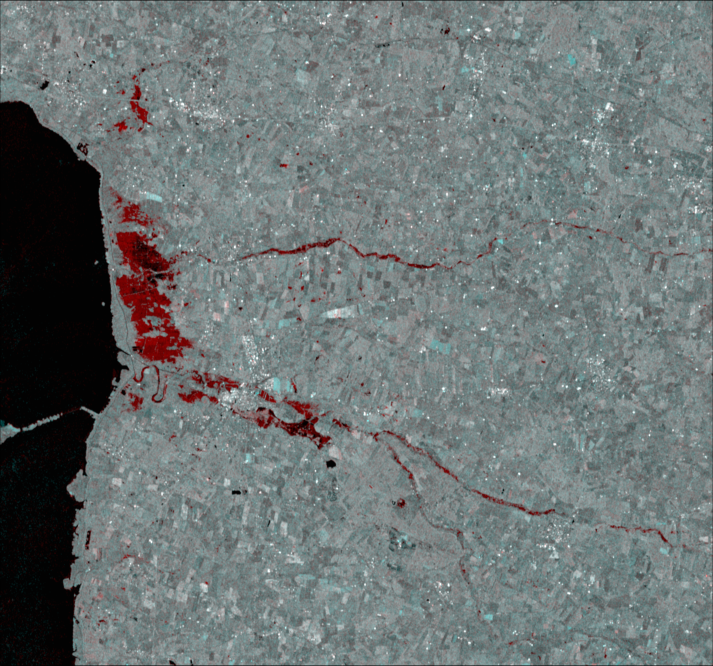

In [5]:
imgVV = pretty_img([VV_co,VV_pre],min_vv,max_vv)

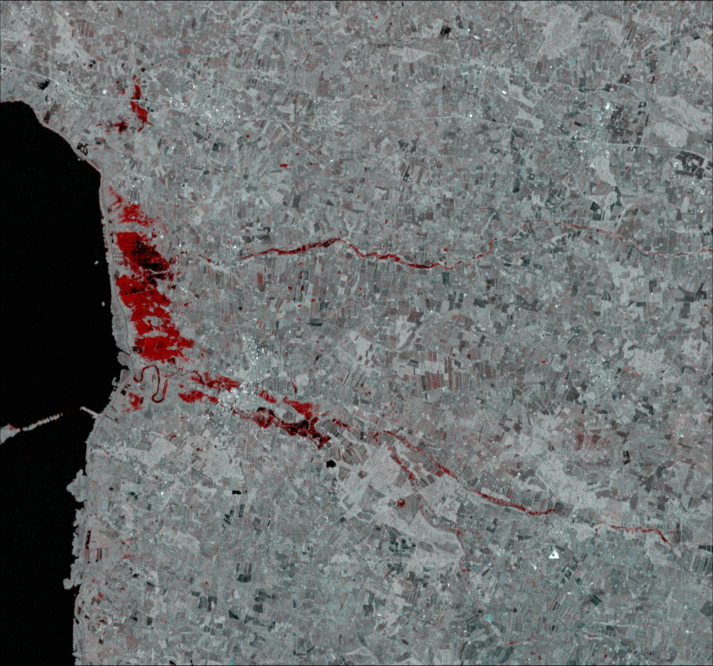

In [6]:
imgVH = pretty_img([VH_co,VH_pre],min_vh,max_vh)

In [8]:
img_bw = pretty_img([VV_co,VV_co],min_vv,max_vv,1);
img_bw_vh = pretty_img([VH_co,VH_co],min_vh,max_vh,1);

In [162]:
VV_co = 10 .*log10.(VV_co)
VV_pre = 10 .*log10.(VV_pre)
VH_co = 10 .*log10.(VH_co)
VH_pre = 10 .*log10.(VH_pre)

delta_VV = VV_co .- VV_pre
delta_VH = VH_co .- VH_pre;

In [168]:
sure_red = (delta_VV.<-2)  .& (delta_VH.<-2) .& (VV_co .< -3) .& (VH_co .< -7) .& .!sea_mask;

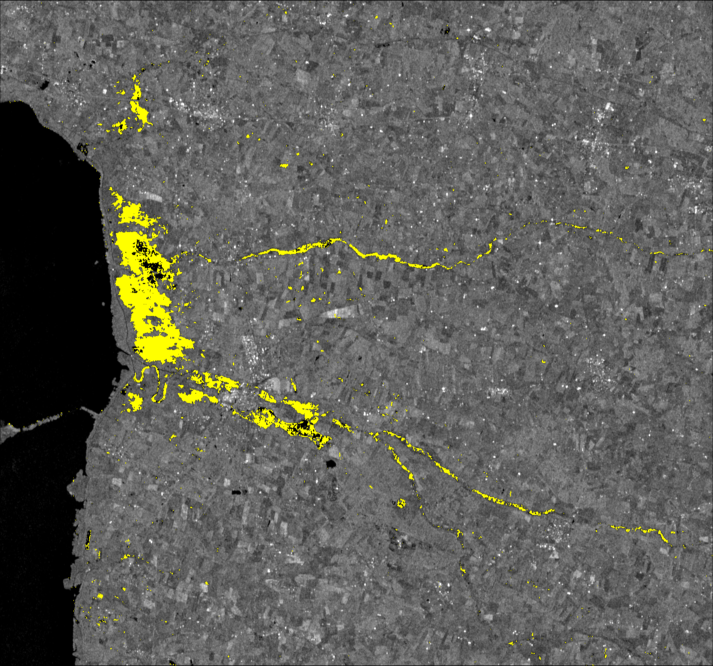

In [169]:
img_save = add_mask(img_bw,sure_red ,(1,1,0))

file_path = joinpath(figure_folder,"own_train")
FileIO.save(file_path*".png",img_save)
img_save

In [170]:
sure_red_VV = vec(VV_co[sure_red])
sure_red_VH = vec(VH_co[sure_red]);

In [171]:
mu_flood = [Statistics.mean(sure_red_VV),Statistics.mean(sure_red_VH)]

2-element Array{Float64,1}:
 -18.210851225173556
 -24.6209991682083  

In [172]:
sigma_flood = Statistics.cov(cat(sure_red_VV,sure_red_VH, dims=2), dims=1)

2×2 Array{Float64,2}:
 9.16531  6.16995
 6.16995  5.79812

In [173]:
x,y = Misc.flatten(-22:0.01:-7,-30:0.01:-12);
mal = get_malhob(x,y,mu_flood,sigma_flood);
distri = Distributions.Chisq(2)
limit = Distributions.quantile.(distri, 0.90)
idx = (limit.<mal ).&( mal.<limit+0.1)
sum(idx)

8502

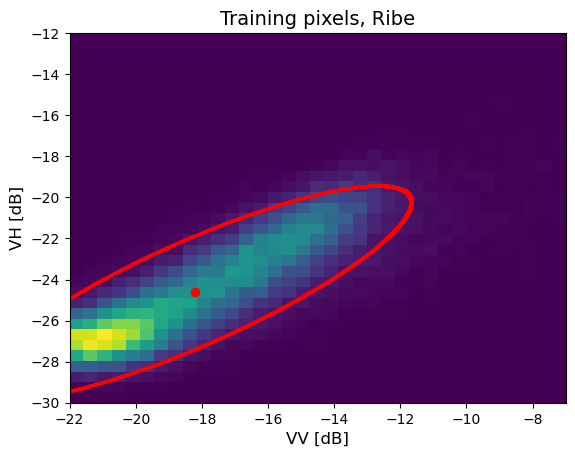

In [174]:
file_path = joinpath(figure_folder,"own_2dhist_train.png")
fig, axes = PyPlot.subplots()
axes.hist2d(sure_red_VV ,sure_red_VH,bins=35,range=[[-22,-7],[-30,-12]]);
axes.scatter(mu_flood[1],mu_flood[2],color="r")
axes.scatter(x[idx],y[idx],color="r",s=1)
PyPlot.xlabel("VV [dB]", fontsize=12)
PyPlot.ylabel("VH [dB]", fontsize=12)
PyPlot.title("Training pixels, Ribe",fontsize=14)
PyPlot.savefig(file_path)

In [175]:
seed_mask = (delta_VV.<-2) .& (VV_co .< mu_flood[1]) .& (delta_VH.<-2) .& (VH_co .< mu_flood[2]);
seed_mask = seed_mask .& .!sea_mask;


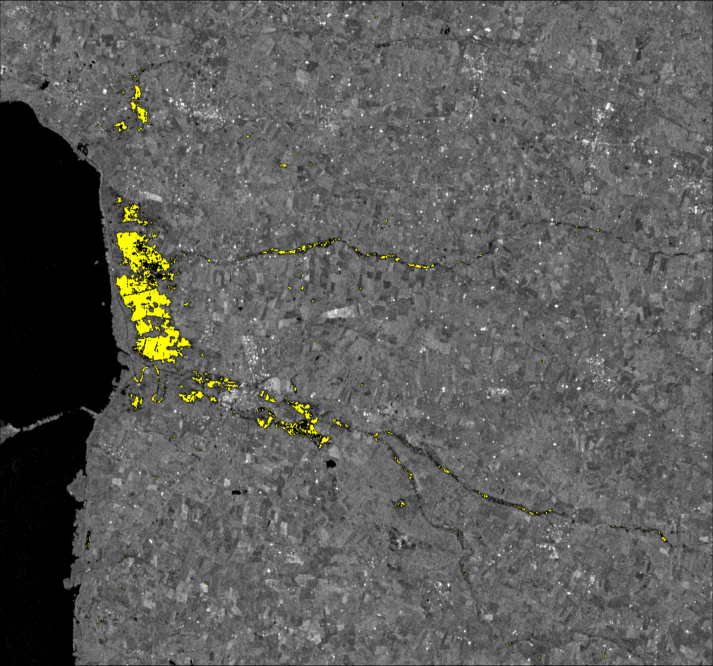

In [176]:
img_save = add_mask(img_bw,seed_mask ,(1,1,0))

file_path = joinpath(figure_folder,"own_seed_bare_soil")
FileIO.save(file_path*".png",img_save)
img_save

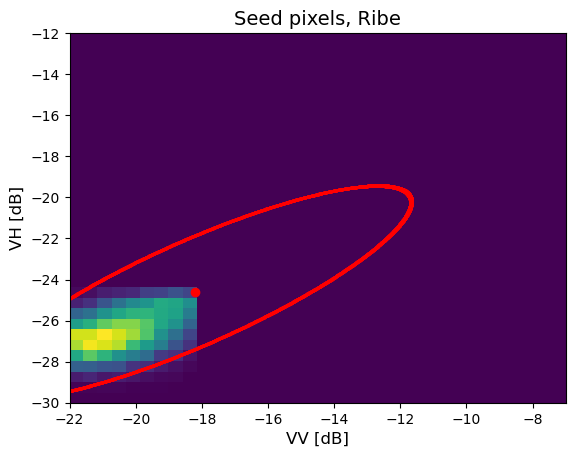

In [177]:
file_path = joinpath(figure_folder,"own_2dhist_seed.png")
fig, axes = PyPlot.subplots()
axes.hist2d(vec(VV_co[seed_mask]) ,vec(VH_co[seed_mask]),bins=35,range=[[-22,-7],[-30,-12]]);
axes.scatter(mu_flood[1],mu_flood[2],color="r")
axes.scatter(x[idx],y[idx],color="r",s=1)
PyPlot.xlabel("VV [dB]", fontsize=12)
PyPlot.ylabel("VH [dB]", fontsize=12)
PyPlot.title("Seed pixels, Ribe",fontsize=14)
PyPlot.savefig(file_path)

In [178]:
rg_mask_change = ((delta_VV.<-2) .& (delta_VH.<0)) .| 
                ((delta_VV.<0) .& (delta_VH.<-2)) .| ( ( (delta_VV .+2).^2 .+ (delta_VH .+2).^2) .< 4 );
rg_mask_change = rg_mask_change .& .!sea_mask;

In [179]:
test_d = collect(1:0.2:12);
dist_cir = (VV_co.-mu_flood[1]).^2 .+ (VH_co .-mu_flood[2]).^2
loss_mal = [loss_rg_fit(VV_co,VH_co, seed_mask, rg_mask_change,mu_flood,sigma_flood,dist_cir, d.^2) for d in test_d ];

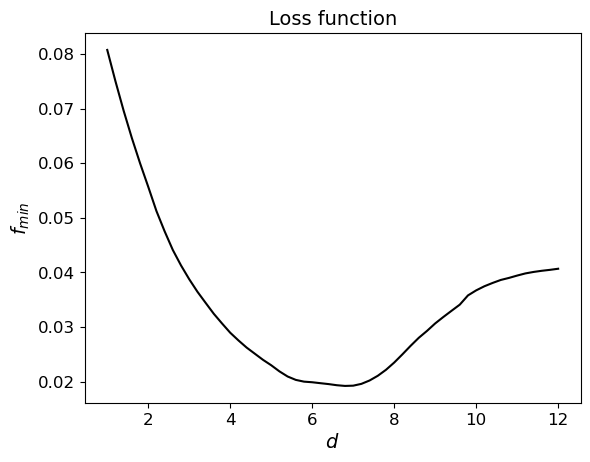

In [180]:
file_path = joinpath(figure_folder,"own_loss_d.png")
PyPlot.figure()
PyPlot.plot(test_d,loss_mal,color="k")
PyPlot.xlabel("\$ d \$", fontsize=14)
PyPlot.ylabel("\$ f_{min} \$", fontsize=14)
PyPlot.xticks( fontsize=12)
PyPlot.yticks(fontsize=12)
PyPlot.title("Loss function", fontsize=14)
PyPlot.savefig(file_path)

In [181]:
res = Optim.optimize(
    d -> loss_rg_fit(VV_co,VH_co, seed_mask, rg_mask_change,mu_flood,sigma_flood,dist_cir, d.^2),
    0, 10);
d_min = res.minimizer

6.844301317634092

In [182]:
rg_mask_int = ((VV_co .< mu_flood[1]) .& (VH_co .< mu_flood[2])) .| (dist_cir .< d_min.^2);

In [183]:
flood,steps = region_growing(seed_mask,rg_mask_int .& rg_mask_change);

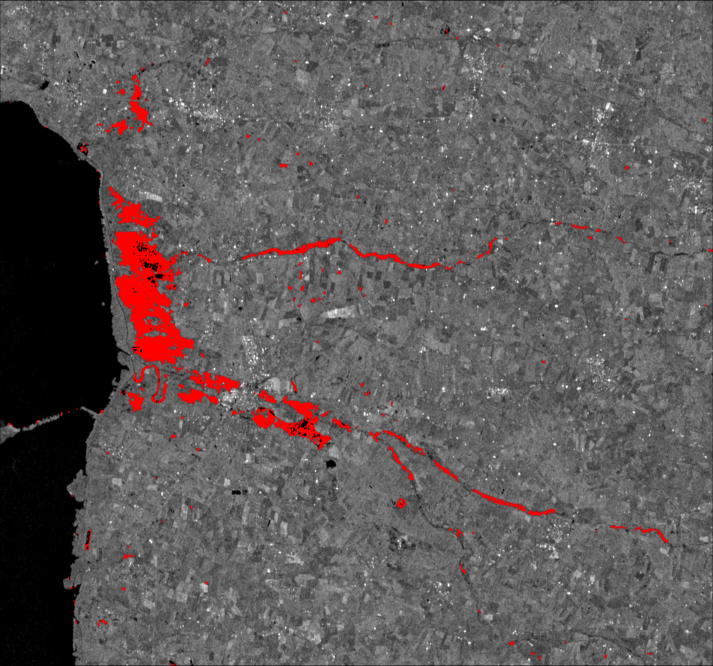

In [184]:
img_save = add_mask(img_bw,flood ,(1,0,0))

file_path = joinpath(figure_folder,"own_bare_soil")
FileIO.save(file_path*".png",img_save)
img_save

In [185]:

file_name = joinpath(data_folder,"own_bare_soil.jld")
JLD.save(file_name, "data",flood);

In [186]:
d_min

6.844301317634092

In [187]:

d_cir2 = ((x.-mu_flood[1]).^2 .+ (y.-mu_flood[2]).^2)
idx2 = (d_min^2 .<d_cir2 ).&(d_cir2 .<d_min^2 +0.2) .& (x .> mu_flood[1]) .& (y .> mu_flood[2])
sum(idx2)

1554

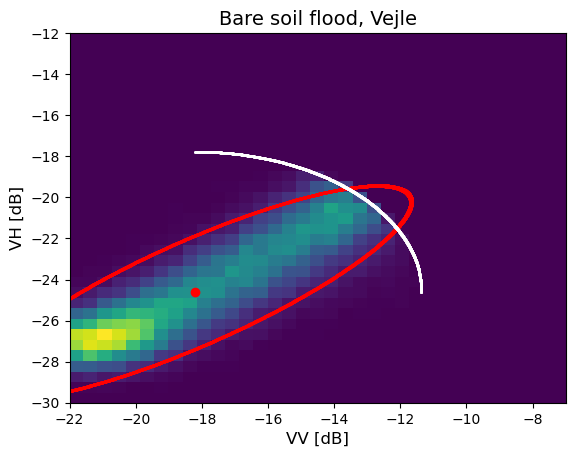

In [188]:
file_path = joinpath(figure_folder,"own_2dhist_bare_soil.png")
fig, axes = PyPlot.subplots()
axes.hist2d(vec(VV_co[flood]) ,vec(VH_co[flood]),bins=35,range=[[-22,-7],[-30,-12]]);
axes.scatter(mu_flood[1],mu_flood[2],color="r")
axes.scatter(x[idx],y[idx],color="r",s=1)
axes.scatter(x[idx2],y[idx2],color="w",s=1)
PyPlot.xlabel("VV [dB]", fontsize=12)
PyPlot.ylabel("VH [dB]", fontsize=12)
PyPlot.title("Bare soil flood, Vejle",fontsize=14)
PyPlot.savefig(file_path)

### Sentinel 2
## hasard

In [5]:
own_bare = JLD.load(joinpath(data_folder,"own_bare_soil.jld"),"data");
water = JLD.load(joinpath(data_folder,"S2_water.jld"),"data");
clouds = JLD.load(joinpath(data_folder,"S2_clouds.jld"),"data");
s2_valid = JLD.load(joinpath(data_folder,"S2_valid.jld"),"data");

In [6]:
no_compare = clouds .| sea_mask .| .!s2_valid ;

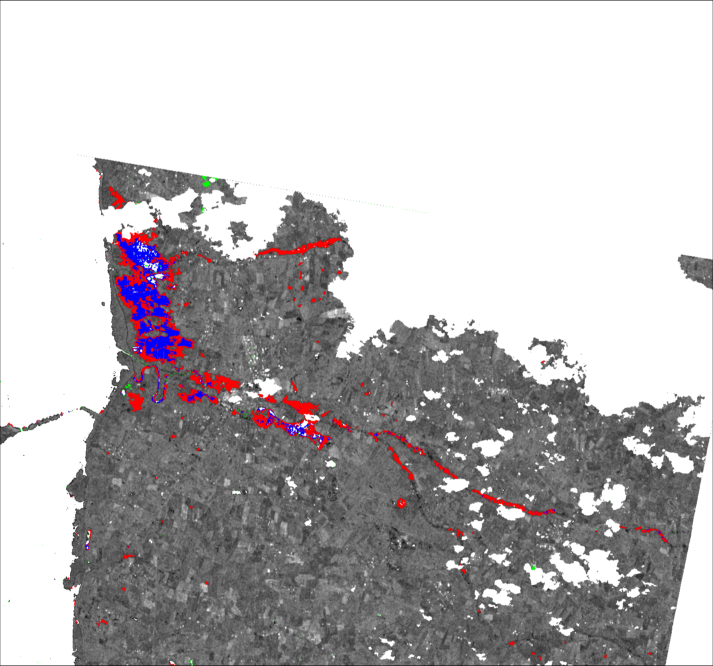

In [9]:
img_save = add_mask(img_bw,water,(0,1,0)) ### Green
img_save = add_mask(img_save,own_bare,(1,0,0)) ### red

img_save = add_mask(img_save,water .&own_bare ,(0,0,1))
img_save = add_mask(img_save,no_compare,(1,1,1)) ###

file_path = joinpath(figure_folder,"rebel_vs_sen2")
FileIO.save(file_path*".png",img_save)
img_save

In [7]:
hsba_vv = JLD.load(joinpath(data_folder,"hsba_VV.jld"),"data");
hsba_vh = JLD.load(joinpath(data_folder,"hsba_VH.jld"),"data");
own_bare = JLD.load(joinpath(data_folder,"own_bare_soil.jld"),"data");
hasard = JLD.load(joinpath(data_folder,"hasard.jld"),"data")[end:-1:1,:].>0.5;

In [ ]:
no_compare

# Hasard

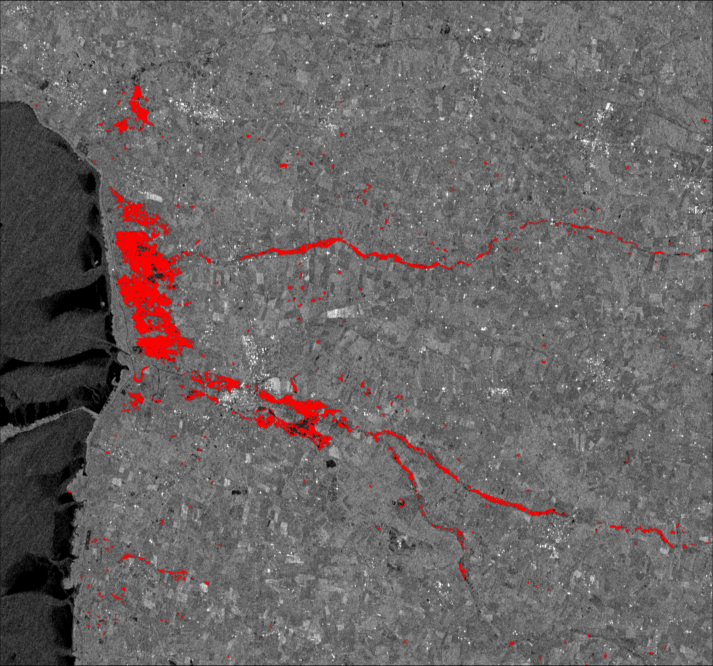

In [60]:
img_save = add_mask(img_bw,hasard ,(1,0,0))

file_path = joinpath(figure_folder,"hasard")
FileIO.save(file_path*".png",img_save)
img_save

In [61]:
flood_maps = [hsba_vv,hsba_vh,own_bare,hasard ];

In [62]:
i =1
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (1.0, 32232)               
 (0.7623136440837894, 16158)
 (0.7971901048668997, 23718)
 (0.6444601304644144, 26477)

In [63]:
i =2
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.5013030528667163, 16158)
 (1.0, 21196)               
 (0.6468808819575155, 19246)
 (0.4602034855418168, 18907)

In [64]:
i =3
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.7358525688756515, 23718)
 (0.9080015097188149, 19246)
 (1.0, 29752)               
 (0.6585288676857171, 27055)

In [65]:
i =4
[(sum(elem .& flood_maps[i])/sum(elem),sum(elem .& flood_maps[i]))  for elem in flood_maps]

4-element Array{Tuple{Float64,Int64},1}:
 (0.8214507321916108, 26477)
 (0.8920079260237781, 18907)
 (0.9093506318902931, 27055)
 (1.0, 41084)               

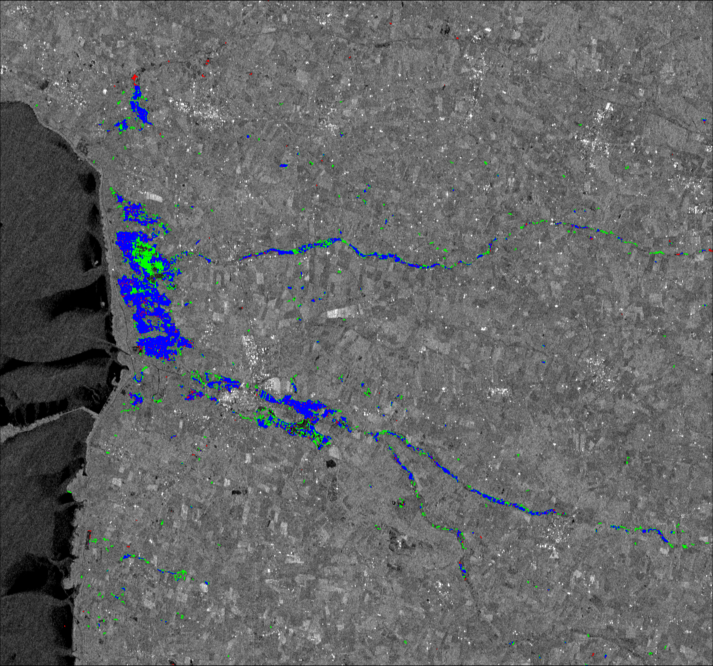

In [8]:
img_save = add_mask(img_bw,hasard,(0,1,0)) ### Green
img_save = add_mask(img_save,own_bare,(1,0,0)) ### red

img_save = add_mask(img_save,hasard .&own_bare ,(0,0,1))

#file_path = joinpath(figure_folder,"hasard_vs_own")
#FileIO.save(file_path*".png",img_save)
img_save

In [16]:
file_path

"/home/data/simon/result/figures_repport/results/ribe/compare_zoom1"

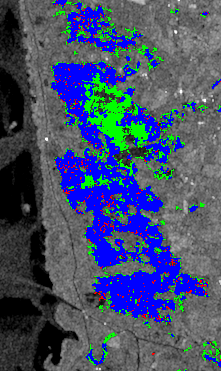

In [21]:

file_path = joinpath(figure_folder,"compare_zoom1")
FileIO.save(file_path*".png",img_save[400:770,180:400])
img_save[400:770,180:400]

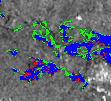

In [38]:
file_path = joinpath(figure_folder,"compare_zoom2")
FileIO.save(file_path*".png",img_save[720:820,350:460])
img_save[720:820,350:460]

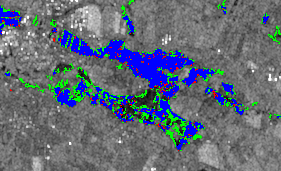

In [39]:
file_path = joinpath(figure_folder,"compare_zoom3")
FileIO.save(file_path*".png",img_save[750:920,460:740])
img_save[750:920,460:740]

In [67]:
zip_folder(figure_folder)

Process(`zip -q -j -r /home/data/simon/result/figures_repport/results/ribe.zip /home/data/simon/result/figures_repport/results/ribe`, ProcessExited(0))

In [ ]:
#### scalgo 